This notebook compares the performance of basic __map__ and __filter__ operators between Rocket.jl, Signals.jl and Reactive.jl. We also compare __map__ operation with Rocket.jl and Observables.jl in synchronous mode.

In [1]:
ENV["REACTIVE_CHANNEL_SIZE"] = 1000000

using Rocket
using BenchmarkTools
using Statistics

import Reactive
import Signals
import Observables

In [2]:
const N = 30000;

In [3]:
# General function for Rocket.jl takes any operator as an argument and sync/async modes
function rocket_jl(operator; scheduler = AsyncScheduler())  
    source = Subject(Int, scheduler = scheduler)
    mapped = source |> operator
    
    # It is also possible to use a KeepActor here, but lets use a lambda here to match with the others
    values = Vector{Int}() 
    
    # sync(...) wraps an actor and allows to 'wait' for completion
    actor  = sync(lambda(on_next = (d) -> push!(values, d))) 
    
    subscribe!(mapped, actor)
    
    yield() # Force to execute of subscribtion task in case of AsyncScheduler
    
    for i in 0:N
        next!(source, i)
    end
    complete!(source)
    
    wait(actor)
    
    return values
end;

#### Map operator

In [4]:
function reactive_jl_map()
    x = Reactive.Signal(0)
    mapped = Reactive.map(a -> a ^ 2, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_map(; async_mode = true)
    Signals.async_mode(async_mode)
    
    x = Signals.Signal(0, strict_push = true)
    m = Signals.Signal(x -> x ^ 2, x)

    values = Vector{Int}()
    Signals.Signal(x -> push!(values, x), m, strict_push = true)
    
    for i in 1:N
        x(i)
    end

    Signals.run_till_now()
    yield()
    
    return values
end

function observables_jl_map()
    x = Observables.Observable(0)
    
    m = map(x -> x ^ 2, x)
    
    values = Vector{Int}()
    Observables.on(m) do v
        push!(values, v)
    end
    
    for i in 0:N
        x[] = i
    end
    
    return values
end

squared_operator = map(Int, d -> d ^ 2);

In [5]:
@assert reactive_jl_map() == observables_jl_map()
@assert reactive_jl_map() == rocket_jl(squared_operator, scheduler = AsyncScheduler())
@assert reactive_jl_map() == rocket_jl(squared_operator, scheduler = AsapScheduler())
@assert reactive_jl_map() == signals_jl_map(async_mode = true)
@assert reactive_jl_map() == signals_jl_map(async_mode = false)

In [6]:
bmap1 = @benchmark reactive_jl_map();
bmap2 = @benchmark signals_jl_map(async_mode = true);
bmap3 = @benchmark signals_jl_map(async_mode = false);
bmap4 = @benchmark rocket_jl($squared_operator, scheduler = AsyncScheduler());
bmap5 = @benchmark rocket_jl($squared_operator, scheduler = AsapScheduler());
bmap6 = @benchmark observables_jl_map();

In [7]:
presult(name, benchmark) = println(name, BenchmarkTools.prettytime(time(benchmark)), " | ", BenchmarkTools.prettymemory(memory(benchmark)))

presult (generic function with 1 method)

In [8]:
presult("Reactive.jl    |         map | ", bmap1)
presult("Signals.jl     | async + map | ", bmap2)
presult("Signals.jl     | sync  + map | ", bmap3)
presult("Rocket.jl      | async + map | ", bmap4)
presult("Rocket.jl      | sync  + map | ", bmap5)
presult("Observables.jl |         map | ", bmap6)

Reactive.jl    |         map | 27.043 ms | 11.01 MiB
Signals.jl     | async + map | 10.924 ms | 15.36 MiB
Signals.jl     | sync  + map | 6.684 ms | 9.18 MiB
Rocket.jl      | async + map | 5.016 ms | 4.67 MiB
Rocket.jl      | sync  + map | 1.775 ms | 3.70 MiB
Observables.jl |         map | 3.817 ms | 2.78 MiB


#### Filter operator

In [9]:
function reactive_jl_filter()
    x = Reactive.Signal(0)
    mapped = Reactive.filter(a -> a % 2 == 0, x)
    values = Vector{Int}()
    stored = Reactive.map(s -> push!(values, s), mapped)
    for i in 1:N
        push!(x, i)
    end
    yield()
    return values
end

function signals_jl_filter(; async_mode = true)
    Signals.async_mode(async_mode)
    
    x = Signals.Signal(0, strict_push = true)
    m = Signals.filter(x -> x % 2 == 0, 0, x)

    values = Vector{Int}()
    Signals.Signal(x -> push!(values, x), m, strict_push = true)
    
    for i in 1:N
        x(i)
    end
    
    Signals.run_till_now()
    yield()
    
    return values
end

even_operator = filter(x -> x % 2 == 0);

In [10]:
@assert reactive_jl_filter() == rocket_jl(even_operator, scheduler = AsyncScheduler())
@assert reactive_jl_filter() == rocket_jl(even_operator, scheduler = AsapScheduler())
@assert reactive_jl_filter() == signals_jl_filter(async_mode = true)
@assert reactive_jl_filter() == signals_jl_filter(async_mode = false)

In [11]:
bfilter1 = @benchmark reactive_jl_filter();
bfilter2 = @benchmark signals_jl_filter(async_mode = true);
bfilter3 = @benchmark signals_jl_filter(async_mode = false);
bfilter4 = @benchmark rocket_jl($even_operator, scheduler = AsyncScheduler());
bfilter5 = @benchmark rocket_jl($even_operator, scheduler = AsapScheduler());

In [12]:
presult("Reactive.jl |         filter | ", bfilter1)
presult("Signals.jl  | async + filter | ", bfilter2)
presult("Signals.jl  | sync  + filter | ", bfilter3)
presult("Rocket.jl   | async + filter | ", bfilter4)
presult("Rocket.jl   | sync  + filter | ", bfilter5)

Reactive.jl |         filter | 26.918 ms | 10.08 MiB
Signals.jl  | async + filter | 11.321 ms | 12.82 MiB
Signals.jl  | sync  + filter | 6.889 ms | 6.65 MiB
Rocket.jl   | async + filter | 4.945 ms | 4.42 MiB
Rocket.jl   | sync  + filter | 1.804 ms | 3.45 MiB


In [13]:
using StatsPlots ; 
using ColorSchemes, Colors ;

pyplot(grid=:false) ; c = palette(:rainbow)

c1 = get(ColorSchemes.rainbow, 0.5) ; 
c2 = get(ColorSchemes.rainbow, 0.2) ; 
c3 = get(ColorSchemes.rainbow, 0.3) ; 
c4 = get(ColorSchemes.rainbow, 0.8) ; 
c5 = get(ColorSchemes.rainbow, 0.9) ; 
c6 = get(ColorSchemes.rainbow, 0.4) ; 

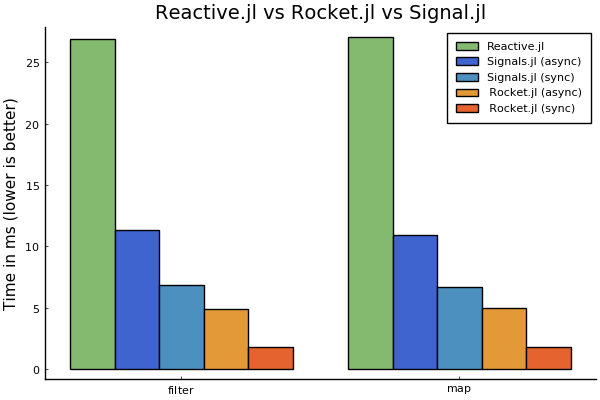

In [14]:
mn = [
    time(bmap1), time(bfilter1),
    time(bmap2), time(bfilter2),
    time(bmap3), time(bfilter3),
    time(bmap4), time(bfilter4),
    time(bmap5), time(bfilter5),
] ./ 1e6
sx = repeat(["Reactive.jl", "Signals.jl (async)", "Signals.jl (sync)", " Rocket.jl (async)", " Rocket.jl (sync)"], inner = 2)
nam = repeat([ " map ", " filter " ], outer = 5)

groupedbar(nam, mn, group = sx, ylabel = "Time in ms (lower is better)", title = "Reactive.jl vs Rocket.jl vs Signal.jl", color=[c1 c2 c3 c4 c5])

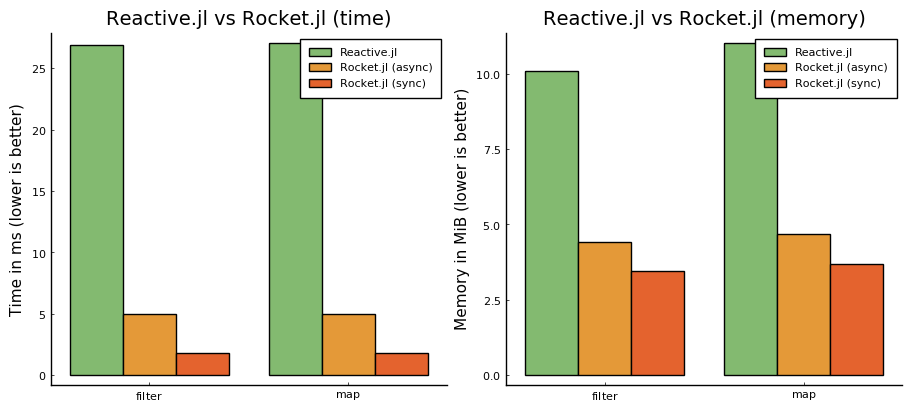

In [15]:
sx = repeat(["Reactive.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 2)
nam = repeat([ " map ", " filter " ], outer = 3)

mn = [
    bmap1, bfilter1,
    bmap4, bfilter4,
    bmap5, bfilter5,
]

p1 = groupedbar(nam, time.(mn)./1e6, group = sx, ylabel = "Time in ms (lower is better)", title = "Reactive.jl vs Rocket.jl (time)", color=[c1 c4 c5], legend=:topright)
p2 = groupedbar(nam, memory.(mn)./2^20, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Reactive.jl vs Rocket.jl (memory)", color=[c1 c4 c5], legend=:topright)

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/reactive-rocket.svg")

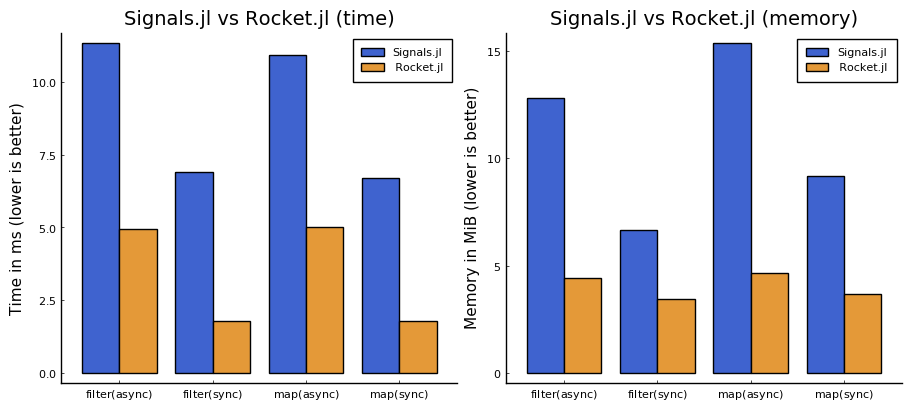

In [16]:
mn = [
    bmap4, bmap5, bfilter4, bfilter5,
    bmap2, bmap3, bfilter2, bfilter3
]

sx = repeat([" Rocket.jl", "Signals.jl"], inner = 4)
nam = repeat([ " map (async) ", " map (sync) ", " filter (async) ", " filter(sync) " ], outer = 2)

p1 = groupedbar(nam, time.(mn)./1e6, group = sx, ylabel = "Time in ms (lower is better)", title = "Signals.jl vs Rocket.jl (time)", color=[c2 c4])
p2 = groupedbar(nam, memory.(mn)./2^20, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Signals.jl vs Rocket.jl (memory)", color=[c2 c4])

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/signals-rocket.svg")

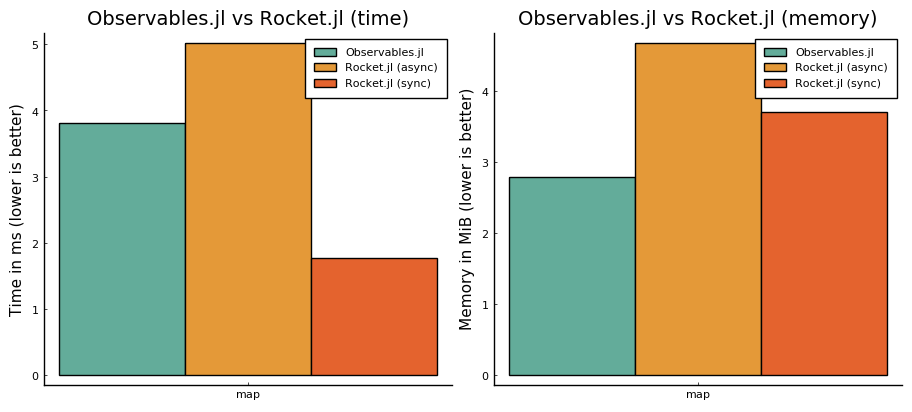

In [17]:
sx = repeat(["Observables.jl", "Rocket.jl (async)", "Rocket.jl (sync)"], inner = 1)
nam = repeat([ " map " ], outer = 3)

mn = [
    bmap6
    bmap4
    bmap5
]

p1 = groupedbar(nam, time.(mn)./1e6, bar_edges = false, group = sx, ylabel = "Time in ms (lower is better)", title = "Observables.jl vs Rocket.jl (time)", color=[c6 c4 c5], legend=:topright)
p2 = groupedbar(nam, memory.(mn)./2^20, bar_edges = false, group = sx, ylabel = "Memory in MiB (lower is better)", title = "Observables.jl vs Rocket.jl (memory)", color=[c6 c4 c5], legend=:topright)

p = plot(p1, p2, size = (900, 400), layout = grid(1, 2))

savefig("pics/observables-rocket.svg")